<a href="https://colab.research.google.com/github/thissop/DROPTABLE2022/blob/main/MAXI-J1535/code/notebooks/December-%202021-2022/triplet_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

## Questions
* I wonder if my data is linearly seperatable
* I also wonder if it would benefit from dimensionality reduction (I don't think so though, because wouldn't the incorporation of noisy, non informative features like $T_{in}$ make the reduced distribution noisy as well, thus clouding the informative information derived from hardness and intensity

## Tasks
* **During CSA:** set up pipelines for k-fold cross validation, pipelines for grid searches for all models, pipelines for changing the data based on the model being used (e.g. dropping rows, missing data, binary flags), etc.  

## Models

* **SVM**
    * **General Plan**: multi-output chaining with bad rows dropped and with bad rows kept
    * Whereas models like Naive-Bayes are examples of generative classification (because they attempt to model different classes), models like SVM are called discriminative classifiers because they simply try to divide the classes from eachother (in this case by finding lines/curves in 2D or manifolds in multiple dimensions that split them). 
    * SVM is an example of a maximum margin estimator. 
    * the support vectors are the points that touch the margins. No other points matter in the distribution besides these according to SVM
    * the ```c``` parameter modulates the "hardness" of the svm margins...if it's low then the margins are said to be "soft" and thus can have more points in them...otherwise if it's high then the margins are said to be "hard" and less points can be in them. 
    * Need to read more about the kernel trick i.e. kernel method
    *


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.svm import SVR
from sklearn.svm import LinearSVR


plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family']='serif'
plt.rcParams['figure.dpi']=150

data_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv?token=AQN5JT7ZW3ZKV5EKEEUCVITB3RP4Y')

In [2]:
# Split data into qpo present and qpo absent 

no_qpo_idx = np.where(data_df['first_par1s']==0)[0]
has_qpo_idx = np.where(data_df['first_par1s']!=0)[0]

has_qpo_df = data_df.iloc[has_qpo_idx, :].sample(frac=1)
no_qpo_df = data_df.iloc[no_qpo_idx, :].sample(frac=1)

print(len(has_qpo_df.index))

57


In [3]:
# prepare data for analysis

# QPO DATA

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(has_qpo_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# num QPOS
num_qpos = np.array(has_qpo_df['num_qpos']).reshape(len(has_qpo_df), 1).astype(int)

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

freq1s, freq2s, freq3s = (normalize(np.array(has_qpo_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s, freq2s, freq3s): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals = np.vstack([y_vals, new_arr])

# NO QPO DATA

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness_no_qpo, tins_no_qpo, disk_norms_no_qpo, gammas_no_qpo, nthcomp_norms_no_qpo, intensities_no_qpo) = (normalize(np.array(no_qpo_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals_no_qpo = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness_no_qpo, tins_no_qpo, disk_norms_no_qpo, gammas_no_qpo, nthcomp_norms_no_qpo, intensities_no_qpo): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals_no_qpo = np.vstack([x_vals_no_qpo, new_arr])

# num QPOS
num_qpos_no_qpo = np.array(no_qpo_df['num_qpos']).reshape(len(no_qpo_df), 1).astype(int)

# Y 
y_vals_no_qpo = np.array([], dtype=np.float32).reshape(0, 3)

freq1s_no_qpo, freq2s_no_qpo, freq3s_no_qpo = (normalize(np.array(no_qpo_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s_no_qpo, freq2s_no_qpo, freq3s_no_qpo): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals_no_qpo = np.vstack([y_vals_no_qpo, new_arr])

In [4]:
# General functions

def split_data(x_vals, y_vals, num_qpos): 
    # Train test split
    X_train, X_test, y_train, y_test, qpo_train, qpo_test = train_test_split(x_vals, y_vals, num_qpos, test_size=0.1)
    return X_train, X_test, y_train, y_test, qpo_train, qpo_test

def knn_predict(k, xtrain, ytrain, xtest, ytest): 
    knn = KNeighborsClassifier(k)
    knn.fit(xtrain, ytrain)
    predictions = knn.predict(xtest)
    acc = accuracy_score(predictions, ytest.flatten())

    return acc, predictions

def cullBuffers(x, qpo_classes):
    new_x = np.array([], dtype=np.float64).reshape(0,3)
    for x_row, qpo_class in zip(x, qpo_classes): 
        if qpo_class == 0: 
            new_x = np.vstack([new_x, np.zeros(3)])

        elif qpo_class == 1:
            new_x = np.vstack([new_x, [x_row[0], 0, 0]])

        elif qpo_class == 2: 
            new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

        elif qpo_class == 3: 
            new_x = np.vstack([new_x, x_row[0:3]])

    return new_x

def drop_no_qpo(X_test, y_test, knn_qpo_predictions): 
    non_zero_indices = np.where(knn_qpo_predictions!=0)
    return X_test[non_zero_indices], y_test[non_zero_indices]

In [5]:
# train test splitting and combining

X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 
X_train_no_qpo, X_test_no_qpo, y_train_no_qpo, y_test_no_qpo, qpo_train_no_qpo, qpo_test_no_qpo = split_data(x_vals_no_qpo, y_vals_no_qpo, num_qpos_no_qpo) 

X_train_combined = np.concatenate((X_train, X_train_no_qpo))
X_test_combined = np.concatenate((X_test, X_test_no_qpo))
qpo_train_combined = np.concatenate((qpo_train, qpo_train_no_qpo))
qpo_test_combined = np.concatenate((qpo_test, qpo_test_no_qpo))

y_test_combined = np.concatenate((y_test, y_test_no_qpo))

In [7]:
knn_acc, knn_predictions = knn_predict(7, X_train_combined, qpo_train_combined, X_test_combined, qpo_test_combined)

knn_predictions = knn_predictions.flatten().astype(int)
knn_predictions
knn_acc

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.9473684210526315

In [37]:
# Test some classifier models
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from astropy.stats import sigma_clipped_stats
from sklearn.tree import DecisionTreeClassifier


for model in [GaussianNB, GaussianProcessClassifier, DecisionTreeClassifier, AdaBoostClassifier, KNeighborsClassifier, RandomForestClassifier]: 
    model_name = str(model).split('\'')[1:2][0].split('.')[-1]

    clf = model()
    
    accs_arr = []
    
    n=100
    for i in range(n): 
        X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 
        X_train_no_qpo, X_test_no_qpo, y_train_no_qpo, y_test_no_qpo, qpo_train_no_qpo, qpo_test_no_qpo = split_data(x_vals_no_qpo, y_vals_no_qpo, num_qpos_no_qpo) 
        X_train_combined = np.concatenate((X_train, X_train_no_qpo))
        X_test_combined = np.concatenate((X_test, X_test_no_qpo))
        qpo_train_combined = np.concatenate((qpo_train, qpo_train_no_qpo))
        qpo_test_combined = np.concatenate((qpo_test, qpo_test_no_qpo))
        y_test_combined = np.concatenate((y_test, y_test_no_qpo))

        clf.fit(X_train_combined, np.ravel(qpo_train_combined))
        clf_predictions = clf.predict(X_test_combined)
        accs_arr.append(accuracy_score(clf_predictions, qpo_test_combined))

    acc = sum(accs_arr)/n
    clipped_acc = sigma_clipped_stats(accs_arr, sigma=3)[0]

    print(model_name+' (acc): '+str(acc)+' (clipped): '+str(clipped_acc))

GaussianNB (acc): 0.7331578947368423 (clipped): 0.7331578947368423
GaussianProcessClassifier (acc): 0.8678947368421046 (clipped): 0.8678947368421046
DecisionTreeClassifier (acc): 0.9047368421052623 (clipped): 0.9047368421052623
AdaBoostClassifier (acc): 0.7647368421052634 (clipped): 0.7647368421052634
KNeighborsClassifier (acc): 0.9131578947368411 (clipped): 0.9131578947368411
RandomForestClassifier (acc): 0.9189473684210515 (clipped): 0.9189473684210515


In [40]:
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
kernels = [RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel]
names = ['RBF', 'DotProduct', 'Matern', 'RationalQuadratic', 'WhiteKernel']
for kernel in kernels: 
    kernel = 1.0*kernel(1.0)
    clf = GaussianProcessClassifier(kernel=kernel)
    clf.fit(X_train_combined, np.ravel(qpo_train_combined))
    clf_predictions = clf.predict(X_test_combined)
    acc = accuracy_score(clf_predictions, qpo_test_combined)
    print(kernel,acc)

1**2 * RBF(length_scale=1) 0.8947368421052632
1**2 * DotProduct(sigma_0=1) 0.8421052631578947
1**2 * Matern(length_scale=1, nu=1.5) 0.8947368421052632


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


1**2 * RationalQuadratic(alpha=1, length_scale=1) 0.8947368421052632
1**2 * WhiteKernel(noise_level=1) 0.05263157894736842


## SVM

In [ ]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["RBF", "Linear", "Polynomial"]
model_color = ["m", "c", "g"]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


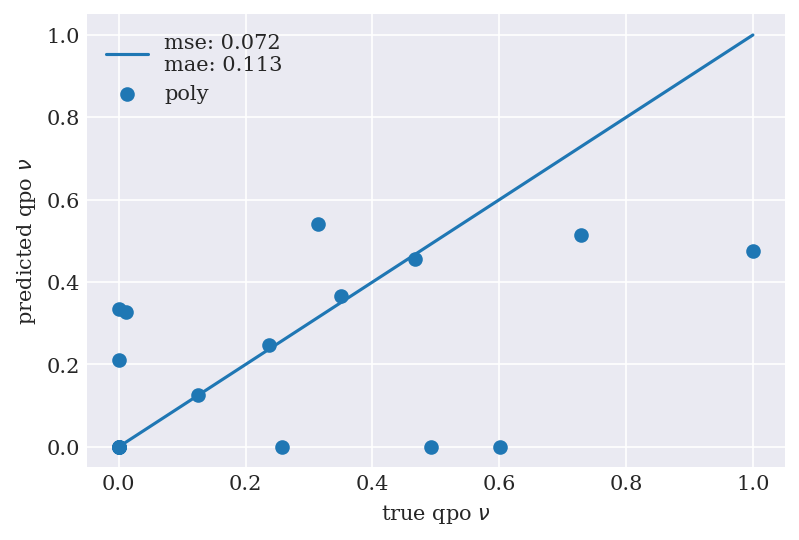

In [ ]:
kernel='poly' # default is rbf, default poly degree is 3

#model = SVR()

model = LinearSVR()

wrapper = RegressorChain(model, order=[0,1,2])

wrapper.fit(X_train,y_train)

x_test_no_qpo_predicted, y_test_no_qpo_predicted = drop_no_qpo(X_test_combined, y_test_combined, knn_predictions)

chained_predictions = cullBuffers(wrapper.predict(x_test_no_qpo_predicted), knn_predictions).flatten()

mse = mean_squared_error(y_test_no_qpo_predicted.flatten(), chained_predictions)
mae = median_absolute_error(y_test_no_qpo_predicted.flatten(), chained_predictions)

fig, ax = plt.subplots()

line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
ax.plot([0,1], [0,1], label=line_label)
ax.scatter(y_test_no_qpo_predicted.flatten(), chained_predictions, label=kernel)

ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')
ax.legend()
plt.show()
plt.clf()
plt.close()